# CS 229B Project - MSM Estimation

## Upload Dataset & Install packages

The FS Peptide dataset contains 28 trajectories, each with 10000 frames.

We need to install packages for data preprocessing (MDTraj) and for the models we are running (PyEMMA, PyTorch).

In [75]:
!wget https://ndownloader.figshare.com/articles/1030363/versions/1 -O fs_peptide.zip
!unzip fs_peptide.zip

zsh:1: command not found: wget
unzip:  cannot find or open fs_peptide.zip, fs_peptide.zip.zip or fs_peptide.zip.ZIP.


In [ ]:
!pip install mdtraj torch pyemma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.1 MB/s eta 0:00:00
  Using cached deeptime-0.4.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 768.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
  Created wheel for mdtraj: filename=mdtraj-1.9.9-cp310-cp310-linux_x86_64.whl size=7547227 sha256=98c5ecfbb4100b9e4623728380db34f04b8a1c25c480ea58

# Load dataset into train/test files

In [1]:
import torch
import random
import numpy as np

In [2]:
def random_seed(seed=42, rank=0):
    torch.manual_seed(seed + rank)
    np.random.seed(seed + rank)
    random.seed(seed + rank)

In [3]:
seed = 7
test_frac = 0.2
train_drop = 0

random_seed(seed=seed)

In [11]:
pdb = 'fs-peptide.pdb'
files = [f'trajectory-{i}.xtc' for i in range(1,29)]
np.random.seed(seed)
train_files = np.random.choice(files, size=int(len(files)* (1-test_frac)), replace=False)
test_files = list(np.setdiff1d(files, train_files))
train_files = list(np.random.choice(train_files, size=int(len(train_files)* (1 - train_drop)), replace=False))

In [12]:
print(train_files)
print(test_files)

['trajectory-15.xtc', 'trajectory-27.xtc', 'trajectory-22.xtc', 'trajectory-17.xtc', 'trajectory-25.xtc', 'trajectory-11.xtc', 'trajectory-13.xtc', 'trajectory-10.xtc', 'trajectory-8.xtc', 'trajectory-28.xtc', 'trajectory-19.xtc', 'trajectory-1.xtc', 'trajectory-6.xtc', 'trajectory-24.xtc', 'trajectory-9.xtc', 'trajectory-21.xtc', 'trajectory-18.xtc', 'trajectory-14.xtc', 'trajectory-7.xtc', 'trajectory-12.xtc', 'trajectory-2.xtc', 'trajectory-3.xtc']
['trajectory-16.xtc', 'trajectory-20.xtc', 'trajectory-23.xtc', 'trajectory-26.xtc', 'trajectory-4.xtc', 'trajectory-5.xtc']


# Build a Markov State Model
This implementation follows the [PyEMMA jupyter notebook tutorials](http://www.emma-project.org/latest/tutorial.html)

In [13]:
import pyemma
import matplotlib.pyplot as plt
import mdtraj as md

In [14]:
traj0 = 'trajectory-1.xtc'


In [15]:
pdb = 'fs-peptide.pdb'

### Featurize

In [16]:
# grab phi and psi indices: will give quadruplets of atom indices that define psi and phi angles
traj = md.load_xtc(train_files[0], top=pdb)
psi,_ = md.compute_psi(traj)
phi,_ = md.compute_phi(traj)

#pyemma add_dihedrals needs indices to be (num_pairs, 4)
indices = np.concatenate([phi, psi])

di_feat = pyemma.coordinates.featurizer(pdb)
di_feat.add_dihedrals(indices, cossin=True, periodic=False)
di_data = pyemma.coordinates.load(train_files, features=di_feat)
di_data_concatenated = np.concatenate(di_data)
print("data shape: ", np.array(di_data).shape)

100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.25it/s]


data shape:  (22, 10000, 84)


In [17]:
rmsd_feat = pyemma.coordinates.featurizer(pdb)
rmsd_feat.add_backbone_torsions(cossin=True, periodic=False)
rmsd_feat.add_minrmsd_to_ref(traj0, ref_frame=0)
rmsd_data = pyemma.coordinates.load(train_files, features=rmsd_feat)
print("data shape: ", np.array(rmsd_data).shape)

100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  9.68it/s]

data shape:  (22, 10000, 85)


In [18]:
t_feat = pyemma.coordinates.featurizer(pdb)
t_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(train_files, features=t_feat)
print("data shape: ", np.array(torsions_data).shape)

100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.41it/s]


data shape:  (22, 10000, 84)


In [19]:
heavy_feat = pyemma.coordinates.featurizer(pdb)
heavy_atom_distance_pairs = heavy_feat.pairs(heavy_feat.select_Heavy())
heavy_feat.add_distances(heavy_atom_distance_pairs, periodic=False)
heavy_data = pyemma.coordinates.load(train_files, features=heavy_feat)

100%|███████████████████████████████████████████| 44/44 [00:07<00:00,  5.70it/s]


In [20]:
regular_data = pyemma.coordinates.load(train_files, top=pdb)
print("data shape: ", np.array(regular_data).shape)

getting output of FeatureReader:   0%|                   | 0/22 [00:00<?, ?it/s]/Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/pyemma/coordinates/data/featurization/featurizer.py:896: UserWarning: You have not selected any features. Returning plain coordinates.
  warnings.warn("You have not selected any features. Returning plain coordinates.")
100%|███████████████████████████████████████████| 22/22 [00:02<00:00,  7.62it/s]


data shape:  (22, 10000, 792)


In [21]:
score_phi_psi = pyemma.coordinates.vamp(di_data[:-1], dim=4).score(
                test_data=di_data[-1], score_method='VAMP2')
print('VAMP2-score dihedral angles: {:.2f}'.format(score_phi_psi))

score_phi_psi2 = pyemma.coordinates.vamp(rmsd_data[:-1], dim=4).score(
                test_data=rmsd_data[-1], score_method='VAMP2')
print('VAMP2-score rmsd + backbone torsions: {:.2f}'.format(score_phi_psi2))


/Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.86it/s]
/Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from /Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)


VAMP2-score dihedral angles: 3.95


100%|███████████████████████████████████████████| 21/21 [00:02<00:00,  7.75it/s]


VAMP2-score rmsd + backbone torsions: 3.97


Looking at the VAMP scores, there is not much difference between dihedral angles and rmsd + backbone torsions, but we will continue with dihedral angles

### TICA - regular vs featurized, shows that featurization actually is important!

/Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 57.19it/s]


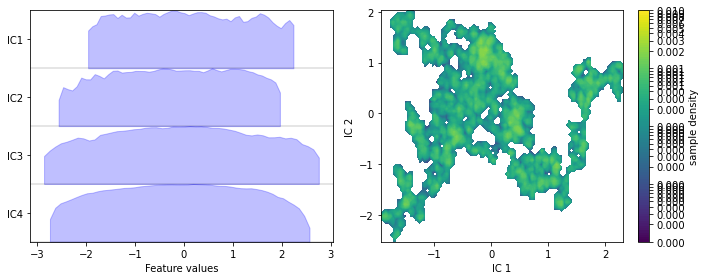

In [23]:
tica_regular = pyemma.coordinates.tica(regular_data, lag=2, dim=4)

tica_regular_output = tica_regular.get_output()

tica_regular_concatenated = np.concatenate(tica_regular_output)


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_regular_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True)
pyemma.plots.plot_density(*tica_regular_concatenated[:, :2].T, ax=axes[1], logscale=True)

axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 {'mappable': <matplotlib.contour.QuadContourSet at 0x4ca84ea40>,
  'cbar': <matplotlib.colorbar.Colorbar at 0x2a146f0a0>})

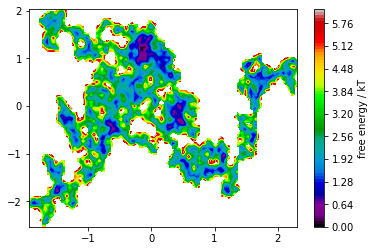

In [24]:
pyemma.plots.plot_free_energy(*tica_regular_concatenated[:, :2].T, legacy=False)

In [25]:


tica = pyemma.coordinates.tica(di_data, lag=2,dim=4)

tica_output = tica.get_output()

tica_concatenated = np.concatenate(tica_output)

/Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 90.36it/s]


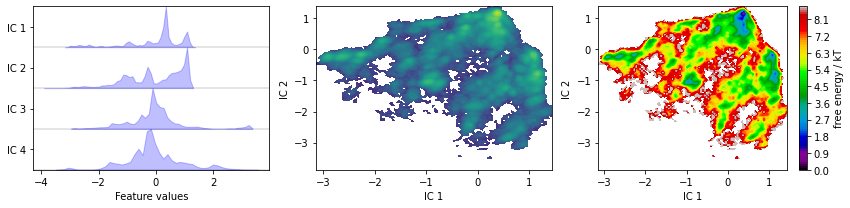

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

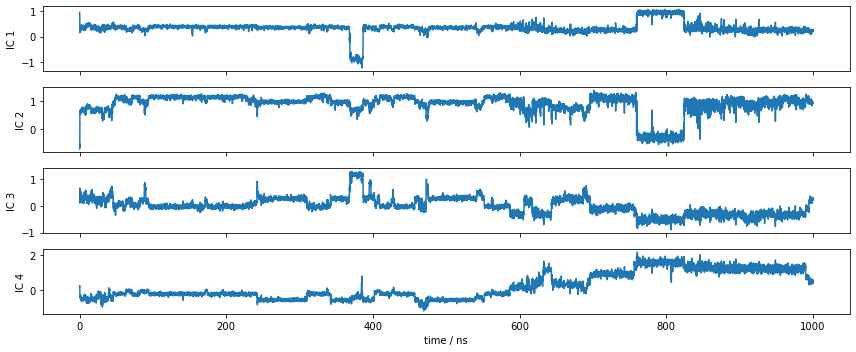

In [28]:

fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()

### Cluster

In [29]:
cluster = pyemma.coordinates.cluster_kmeans(
        tica_output, max_iter=50,k=100)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

/Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.77it/s]

100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 293.97it/s]


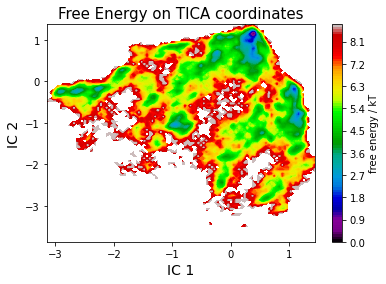

In [30]:
#fig, axes = plt.subplots( figsize=(12, 3))
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, legacy=False)#, colorbar="free energy / kT", fontsize=15)
plt.title('Free Energy on TICA coordinates', fontsize=15)
plt.xlabel('IC 1', fontsize=14)
plt.ylabel('IC 2', fontsize=14)
#plt.colorbar('free energy / kT', fontsize=15)
plt.savefig('TICA_energy.png')

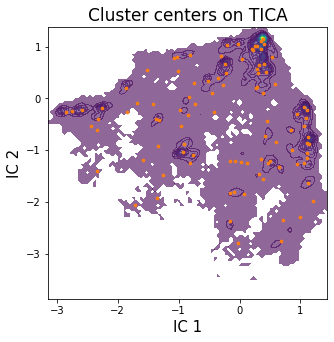

In [31]:
fig, ax = plt.subplots(figsize=(5,5))

pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, cbar=False, ax=ax, alpha=0.6)
ax.scatter(*cluster.clustercenters[:, :2].T, s=7, c='C1')
ax.set_xlabel('IC 1', fontsize=15)
ax.set_ylabel('IC 2', fontsize=15)
plt.title('Cluster centers on TICA',fontsize=17)
plt.savefig('TICA_cluster.png')

# testing data - assign to clusters

In [32]:
# get TICA of testing data
test_feat = pyemma.coordinates.featurizer(pdb)
test_feat.add_dihedrals(indices, cossin=True, periodic=False)
test_data = pyemma.coordinates.load(test_files, features=test_feat)
test_data_concatenated = np.concatenate(test_data)
print("data shape: ", np.array(test_data).shape)

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.35it/s]


data shape:  (6, 10000, 84)


In [33]:

test_tica = pyemma.coordinates.tica(test_data, lag=2,dim=4)


test_tica_output = test_tica.get_output()

test_tica_concatenated = np.concatenate(test_tica_output)

/Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 75.27it/s]


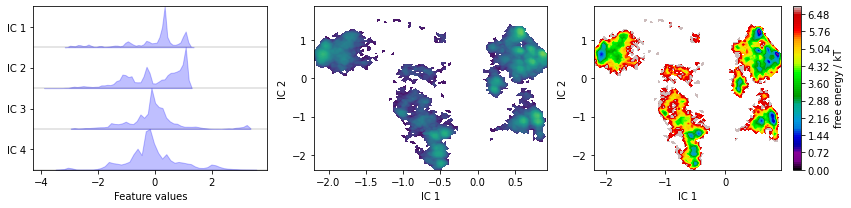

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(test_tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*test_tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*test_tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

In [52]:
# assign the test values with a cluster according to tica value

test_clusters = cluster.assign(test_tica_output)
print(type(test_clusters))
print((np.array(test_clusters)).shape)
train_dtrajs = np.array(cluster.dtrajs)
print(train_dtrajs.shape)

test_dtrajs = np.array(test_clusters)
print((np.array(test_clusters))[0,0:5])
print((np.array(cluster.dtrajs))[0,0:5])

dtrajs = np.concatenate((train_dtrajs, test_dtrajs))
print(dtrajs.shape)
dtrajs = list(dtrajs)
all_dtrajs_concat = np.concatenate(dtrajs)
print(dtrajs_concatenated.shape)
print(all_dtrajs_concat.shape)

<class 'list'>
(6, 10000)
(22, 10000)
[16 16 16 16 16]
[60 60 83 31 31]
(28, 10000)
(220000,)
(280000,)


# Build MSM

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 11.03it/s]


(<Figure size 720x720 with 16 Axes>,
 array([[<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='lag time (ps)', ylabel='probability'>,
         <AxesSubplot:xlabel='lag time (ps)'>,
         <AxesSubplot:xlabel='lag time (ps)'>,
         <AxesSubplot:xlabel='lag time (ps)'>]], dtype=object))

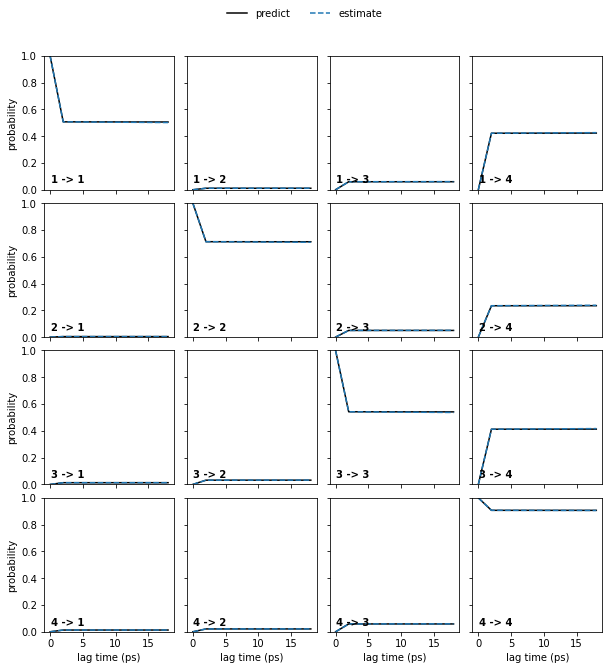

In [36]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=2,dt_traj='50 ps')
pyemma.plots.plot_cktest(msm.cktest(4), units='ps')

In [37]:
msm.pcca(4)

PCCA-20602892592:[{'P': array([[0.92808091, 0.        , 0.        , ..., 0.        , 0.        ,
                         0.        ],
                        [0.        , 0.93256912, 0.        , ..., 0.        , 0.        ,
                         0.        ],
                        [0.        , 0.        , 0.97555472, ..., 0.        , 0.        ,
                         0.        ],
                        ...,
                        [0.        , 0.        , 0.        , ..., 0.98154362, 0.        ,
                         0.        ],
                        [0.        , 0.        , 0.        , ..., 0.        , 0.8943662 ,
                         0.        ],
                        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
                         0.71972956]]),
                  'm': None}]

In [40]:
print(dtrajs_concatenated)
print(max(dtrajs_concatenated))

[60 60 83 ... 70  0  0]
99


In [54]:

for i in range(0, len(dtrajs_concatenated)):
    if dtrajs_concatenated[i] >= 99:
        dtrajs_concatenated[i]-= 1

In [55]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
highest_membership = msm.metastable_distributions.argmax(1)
coarse_state_centers = cluster.clustercenters[msm.active_set[highest_membership]]

print(highest_membership)

[56 38  2  0]


In [56]:
nstates=4
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]

(<Figure size 864x655.642 with 1 Axes>,
 array([[-0.7660111 , -1.1022055 , -1.3025825 , -2.9358654 ],
        [-0.93493986, -1.036961  ,  3.2512968 , -1.5363837 ],
        [-2.579435  , -0.22837351,  0.13209884,  1.2714968 ],
        [ 0.38020337,  1.1437005 , -0.01733659, -0.1932365 ]],
       dtype=float32))

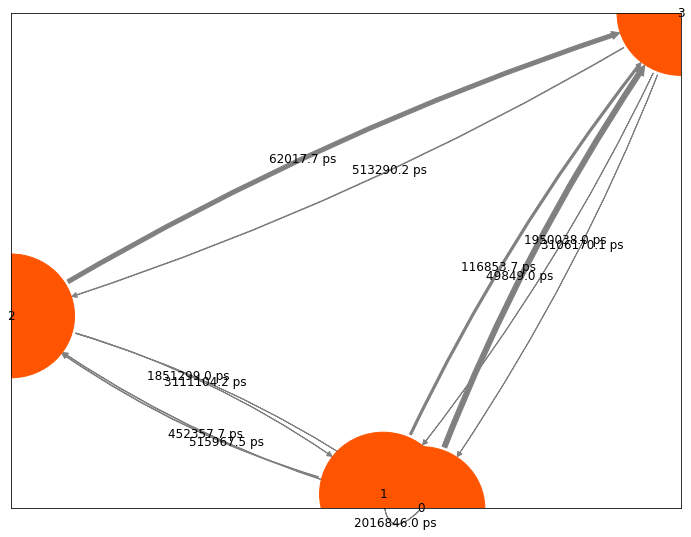

In [57]:

pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers,
    figpadding=0,
    arrow_label_format='%.1f ps',
    arrow_labels=mfpt,
    size=12,
    show_frame=True)


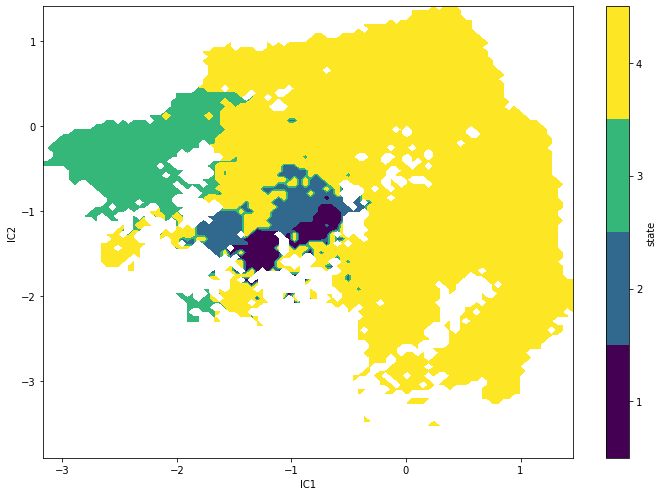

In [58]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    tica_concatenated[:][:,0].T, tica_concatenated[:][:,1].T, ax=ax, states=metastable_traj, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates

ax.set_xlabel('IC1')
ax.set_ylabel('IC2')
fig.tight_layout()

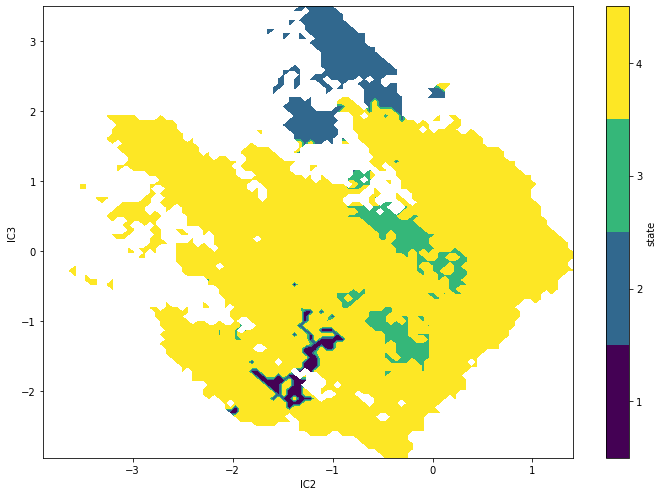

In [59]:
fig, ax = plt.subplots(figsize=(10, 7))
_, _, misc = pyemma.plots.plot_state_map(
    tica_concatenated[:][:,1].T, tica_concatenated[:][:,2].T, ax=ax, states=metastable_traj, zorder=-1)
misc['cbar'].set_ticklabels(range(1, nstates + 1))  # set state numbers 1 ... nstates



ax.set_xlabel('IC2')
ax.set_ylabel('IC3')
fig.tight_layout()

# Generate sample trajectories from MSM we've built

In [60]:
test_dtrajs = np.array(test_clusters)

In [62]:
# start from beginning of test file 
all_rmsds = []
for i in range(0, len(test_files)):
    print(i, end="")
    i_clustering = test_dtrajs[i,:]
    traj = md.load_xtc(test_files[i], top=pdb)
    rmsds = []
    for j in range(0,10000-1, 100):
        print('.', end="")
        initial_state = i_clustering[j]
        generated_traj = msm.generate_traj(1, start=initial_state)
        target_traj = md.load_xtc(train_files[generated_traj[0][0]], top=pdb)
        target_frame = target_traj[generated_traj[0][1]]
        rmsd = md.rmsd(target_frame,traj, j+1)
        rmsds.append(rmsd[0])
    print("!")
        
    
    #if j % 100:
    #print(j)
        
    all_rmsds.append(rmsds)
    #

0..

/Users/lreeder/miniforge3/envs/cryo/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


..................................................................................................!
1....................................................................................................!
2....................................................................................................!
3....................................................................................................!
4....................................................................................................!
5....................................................................................................!


In [63]:
np.array(all_rmsds).shape

(6, 100)

In [64]:
all_rmsds = np.array(all_rmsds)
print(all_rmsds.shape)
avg_rmsds = np.mean(all_rmsds, axis=0)
print(avg_rmsds.shape)

(6, 100)
(100,)


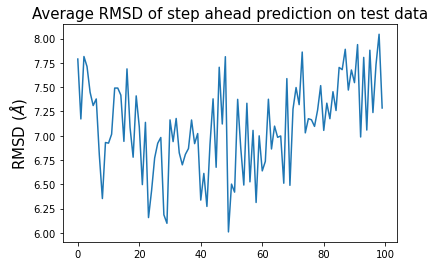

In [65]:
avg_rmsds = np.mean(all_rmsds, axis=0)
avg_rmsds = avg_rmsds*10

plt.plot(range(0,100), avg_rmsds)
plt.ylabel('RMSD ($\AA$)', fontsize=15)
plt.title('Average RMSD of step ahead prediction on test data', fontsize=15)
#plt.legend()
plt.savefig('RMSD_TEST.png')


In [66]:
print(np.mean(avg_rmsds))

7.102154
